In [1]:
import fastai
from fastai.imports import *
from fastai.vision import *
from fastai.metrics import *
from fastai.gen_doc.nbdoc import *
print('fast.ai version:{}'.format(fastai.__version__))

fast.ai version:1.0.51


In [2]:
model = models.resnet152#resnet34
WORK_DIR = os.getcwd()
IMAGE_DIR = Path('../input/')
image_size=224
batch_size=32

fnames = get_image_files(IMAGE_DIR/'train')
fnames[:5]

[PosixPath('../input/train/cat.11679.jpg'),
 PosixPath('../input/train/dog.2811.jpg'),
 PosixPath('../input/train/dog.2578.jpg'),
 PosixPath('../input/train/dog.9238.jpg'),
 PosixPath('../input/train/dog.7504.jpg')]

In [3]:
pattern_get_class = re.compile(r'/([^/]+)\.\d+\.jpg$')
data = ImageDataBunch.from_name_re(path = IMAGE_DIR,
                                   fnames = fnames, 
                                   pat = pattern_get_class, 
                                   ds_tfms=get_transforms(), 
                                   test ='test',
                                   size=image_size, 
                                   bs=batch_size,
                                   num_workers=0).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (20000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cat,dog,dog,dog,dog
Path: ../input;

Valid: LabelList (5000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dog,dog,dog,cat,cat
Path: ../input;

Test: LabelList (12500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ../input

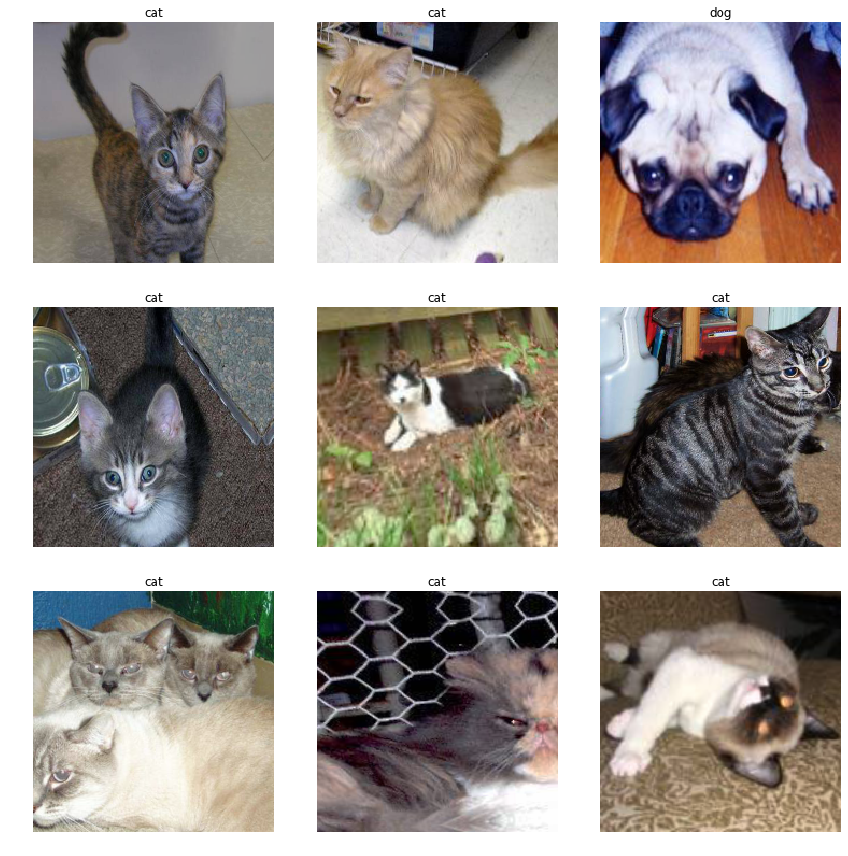

In [4]:
data.show_batch(rows=3)

In [5]:
learn = create_cnn(data, model, metrics=accuracy, model_dir=WORK_DIR)

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.torch/models/resnet152-b121ed2d.pth
241530880it [00:02, 92142796.82it/s]


In [6]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.043247,0.018451,0.993600,09:02


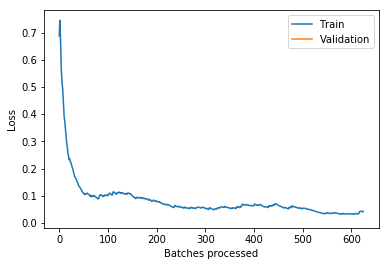

In [7]:
learn.recorder.plot_losses()

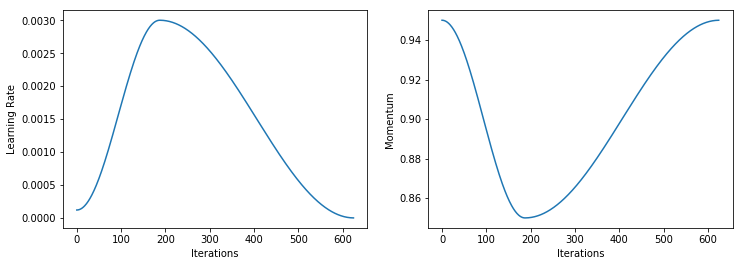

In [8]:
learn.recorder.plot_lr(show_moms=True)
# Left plot is Learning-Rate vs itteration, Right one is momentams vs itteration.

In [9]:
learn.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


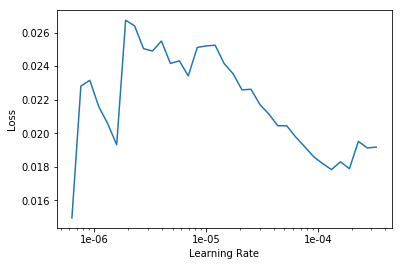

In [10]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.load('stage-1')
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.028880,0.018897,0.994600,09:53
1,0.025187,0.018176,0.994200,09:49
2,0.015188,0.014458,0.995800,09:47
3,0.016262,0.013559,0.995600,09:45


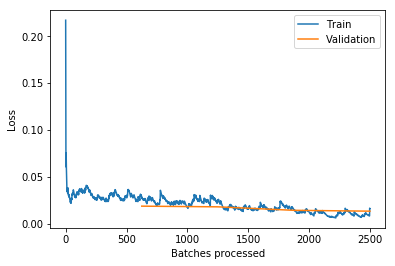

In [12]:
learn.recorder.plot_losses()

In [13]:
learn.save('stage-2')

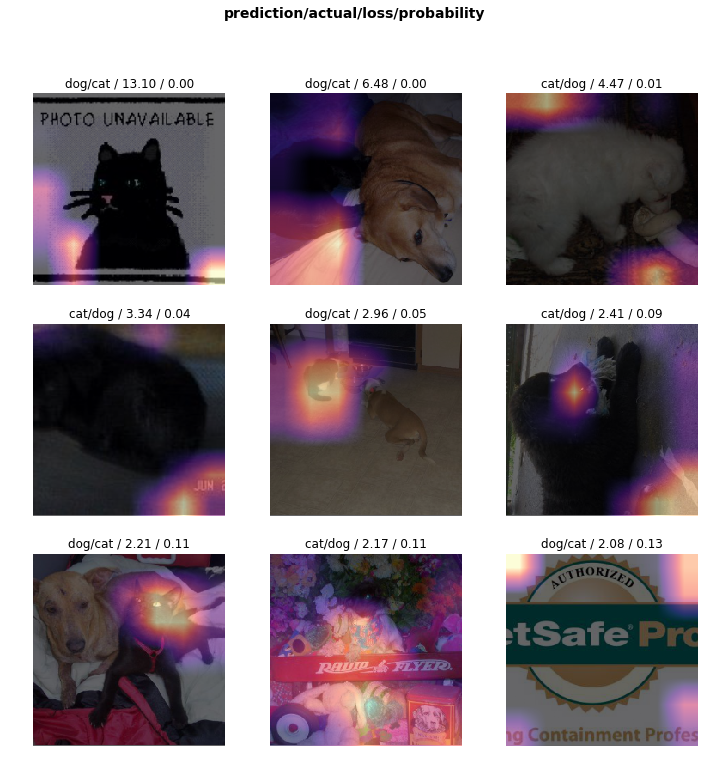

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

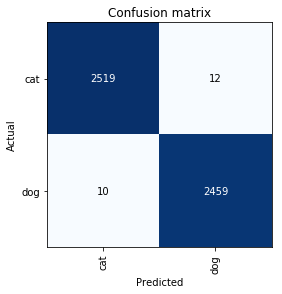

In [15]:
interp.plot_confusion_matrix()

In [16]:
if 'DatasetType' not in sys.modules:
    from fastai import DatasetType

ImportError: cannot import name 'DatasetType'

In [17]:
try:
    # TTA cause error @fast.ai v1.0.39
    preds, _ = learn.TTA(ds_type=DatasetType.Test)
except:
    preds, _ = learn.get_preds(DatasetType.Test)
else:
    print('Predict with TTA done.')

Predict with TTA done.


In [18]:
preds

tensor([[9.9977e-01, 2.3404e-04],
        [9.9992e-01, 8.3349e-05],
        [9.9996e-01, 4.1633e-05],
        ...,
        [9.9995e-01, 5.2445e-05],
        [7.6950e-01, 2.3050e-01],
        [9.9953e-01, 4.6954e-04]])

In [19]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
print(data.classes)
dict_label_order = {label:order for order,label in enumerate(data.classes)}
print(dict_label_order)

['cat', 'dog']
{'cat': 0, 'dog': 1}


In [20]:
n_dogs = dict_label_order['dog']
n_dogs

1

In [21]:
prob_dogs = preds[:,n_dogs].numpy()
prob_dogs

array([2.340417e-04, 8.334950e-05, 4.163342e-05, 9.940288e-01, ..., 9.996176e-01, 5.244454e-05, 2.305022e-01,
       4.695405e-04], dtype=float32)

(array([6.108e+03, 8.300e+01, 4.300e+01, 6.000e+00, 1.300e+01, 1.000e+01, 2.800e+01, 6.400e+01, 1.740e+02, 5.971e+03]),
 array([2.953811e-07, 1.000002e-01, 2.000002e-01, 3.000001e-01, 4.000001e-01, 5.000000e-01, 6.000000e-01, 6.999999e-01,
        7.999999e-01, 8.999998e-01, 9.999998e-01], dtype=float32),
 <a list of 10 Patch objects>)

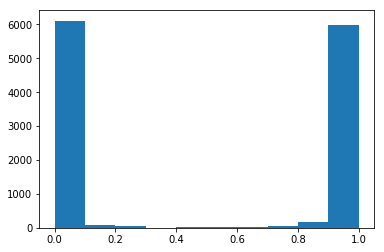

In [22]:
plt.hist(prob_dogs)

In [23]:
ids = [int(file.stem) for file in data.test_ds.x.items]
ids[:10]

[3090, 8785, 10679, 7247, 8151, 1621, 10255, 7723, 11953, 6162]

In [24]:
import pandas as pd
submission = pd.DataFrame({'id':ids,'label':prob_dogs})
submission = submission.sort_values(by=['id'])

In [25]:
submission.head()

,id,label
2322,1,0.999770
5025,2,0.999939
2481,3,0.999703
5068,4,0.999972
3495,5,0.000038


In [26]:
submission.to_csv('submission.csv', index=False)